# Text Summarization 

<div style="background-color:#cdd3dd; color:##cdd3dd; font-size:18px; font-family:cursive; padding:10px; border: 5px solid #19180F;">Text summarization is the process of condensing a longer piece of text into a shorter version while preserving the main ideas and key information. It aims to capture the essence of the original text and present it in a concise and coherent manner. The goal of text summarization is to save time and effort for readers by providing a summary that captures the most important points of the document.</div>



# Two types of Text Summarization 

<div style="background-color:#cdd3dd; color:##cdd3dd; font-size:18px; font-family:cursive; padding:10px; border: 5px solid #19180F;">
    
* Extractive Summarization: This approach involves selecting the most relevant sentences or phrases from the original text and combining them to form a summary. Extractive summarization methods typically rank sentences based on their importance, using techniques such as frequency analysis, statistical methods, or machine learning algorithms. The selected sentences are then arranged to create a coherent summary.

* Abstractive Summarization: In contrast to extractive summarization, abstractive summarization aims to generate a summary that may contain words, phrases, or even sentences that were not present in the original text. It involves understanding the meaning of the text and generating a summary in a more human-like manner. Abstractive methods often employ natural language processing (NLP) techniques, such as language generation models, to paraphrase and generate new sentences that capture the essential information.<div>

# Building Text Summarizer using BART

<div style="background-color:#cdd3dd; color:##cdd3dd; font-size:18px; font-family:cursive; padding:10px; border: 5px solid #19180F;">In this notebook we will build Text summarizer (Abstractive Summarization) using BART, we will fine-tune BART using BBC News Summary dataset which contains 2225 pair of nwes and its summaries.  </div>


# BART


<div style="background-color:#cdd3dd; color:##cdd3dd; font-size:18px; font-family:cursive; padding:10px; border: 5px solid #19180F;">
BART (Bidirectional and Auto-Regressive Transformers) is a sequence-to-sequence model introduced by Facebook AI Research. It is based on the Transformer architecture and is designed for various natural language processing tasks, including text generation, text completion, and text classification.

BART combines ideas from both autoencoders and autoregressive models. It consists of an encoder-decoder architecture, where the encoder reads the input text and the decoder generates the output text. BART has a bidirectional structure, meaning it can take into account both the left and right context of a given word when generating the output sequence. </div>

# BART's Architectural Diagram

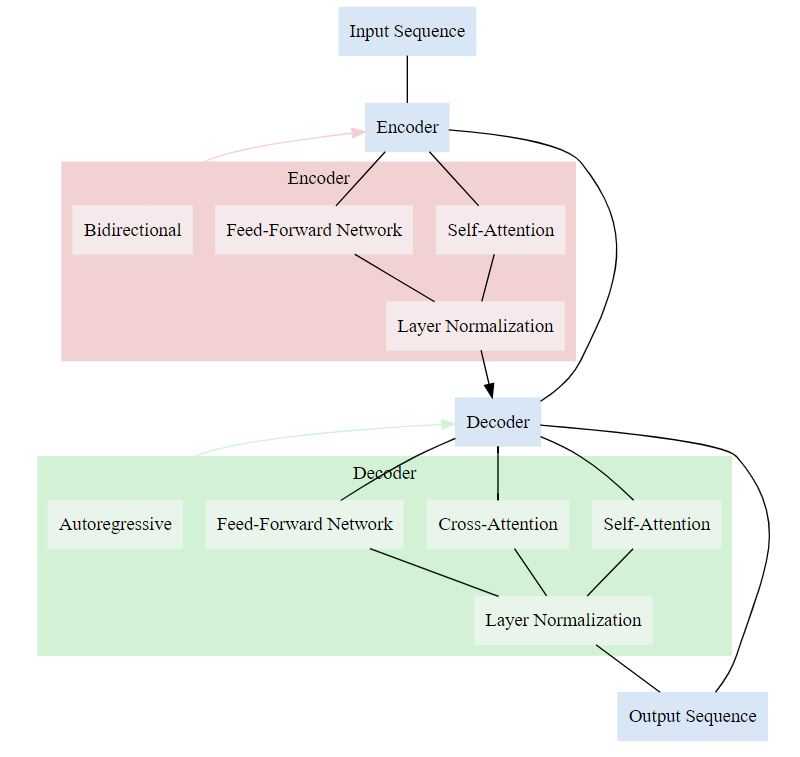

# Importing the requirements 

In [1]:
!pip install rouge_score
!pip install evaluate
!pip install --upgrade -q wandb

  Preparing metadata (setup.py) ... - \ done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=a17238e7d51f571b3bbc01ea251672aa085096f3f0df3a93b86acce9aef43e23
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.8 MB/s eta 0:00:00


In [2]:
import pandas as pd 
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline, set_seed
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

import datasets
from datasets import load_metric, Dataset
from datasets import DatasetDict

from tqdm import tqdm

import wandb

import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt")

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# kaggle_secrets to use the tokens from huggingface and wandb 

from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("text-summarizer")
secret_value_1 = user_secrets.get_secret("wandb")

In [4]:
wandb.login(key = secret_value_1)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# log in to the Hugging Face Hub

import huggingface_hub

huggingface_hub.login(token=secret_value_0)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "facebook/bart-base"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

# Data Anlaysis

In [7]:
paths = os.listdir('../input/bbc-news-summary/BBC News Summary/News Articles')
articles_path = '../input/bbc-news-summary/BBC News Summary/News Articles/'
summaries_path = '../input/bbc-news-summary/BBC News Summary/Summaries/'

articles = []
summaries = []
file_arr = []

for path in paths:
    files = os.listdir(articles_path + path)
    for file in files:
        article_file_path = articles_path + path + '/' + file
        summary_file_path = summaries_path + path + '/' + file
        try:
            with open (article_file_path,'r') as f:
                articles.append('.'.join([line.rstrip() for line in f.readlines()]))
            with open (summary_file_path,'r') as f:
                summaries.append('.'.join([line.rstrip() for line in f.readlines()]))
            file_arr.append(path + '/' + file)
        except:
            pass

In [8]:
df = pd.DataFrame({'path':file_arr,'article': articles,'summary':summaries})
df.head()

,path,article,summary
0,politics/361.txt,Budget to set scene for election..Gordon Brown...,- Increase in the stamp duty threshold from £6...
1,politics/245.txt,Army chiefs in regiments decision..Military ch...,"""They are very much not for the good and will ..."
2,politics/141.txt,Howard denies split over ID cards..Michael How...,Michael Howard has denied his shadow cabinet w...
3,politics/372.txt,Observers to monitor UK election..Ministers wi...,The report said individual registration should...
4,politics/333.txt,Kilroy names election seat target..Ex-chat sho...,"UKIP's leader, Roger Knapman, has said he is g..."


In [9]:
# removing nans if any

df.dropna(inplace=True)
df.isnull().sum()

path       0
article    0
summary    0
dtype: int64

In [10]:
# crating function to count the words in each sample

def word_count(sentence):
    sentences = sentence.split()
    return len(sentences)

In [11]:
# creating new columns of word numbers

df['num_words_article'] = df['article'].apply(word_count)
df['num_words_summary'] = df['summary'].apply(word_count)
df.head()

,path,article,summary,num_words_article,num_words_summary
0,politics/361.txt,Budget to set scene for election..Gordon Brown...,- Increase in the stamp duty threshold from £6...,532,192
1,politics/245.txt,Army chiefs in regiments decision..Military ch...,"""They are very much not for the good and will ...",496,266
2,politics/141.txt,Howard denies split over ID cards..Michael How...,Michael Howard has denied his shadow cabinet w...,533,225
3,politics/372.txt,Observers to monitor UK election..Ministers wi...,The report said individual registration should...,490,223
4,politics/333.txt,Kilroy names election seat target..Ex-chat sho...,"UKIP's leader, Roger Knapman, has said he is g...",435,185


In [12]:
# getting statistical info about the word lenghths

df.describe()

,num_words_article,num_words_summary
count,2224.000000,2224.000000
mean,379.286871,165.151529
std,235.081995,108.678038
min,87.000000,38.000000
25%,242.000000,103.000000
50%,327.000000,142.000000
75%,465.250000,202.000000
max,4377.000000,2073.000000


Upper whisker: 799.0
Q3: 465.25
Q2: 327.0
Q1: 242.0
Lower whisker: 87.0


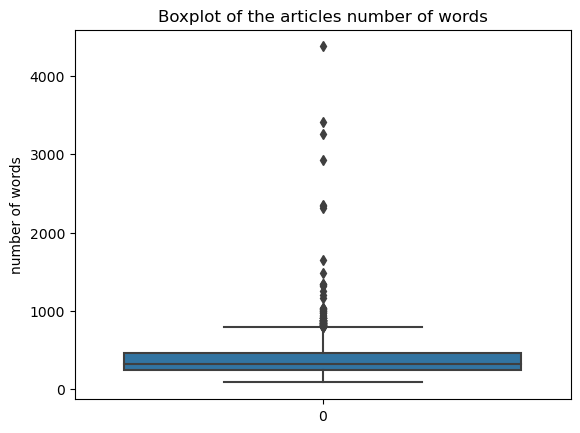

In [13]:
sns.boxplot(df["num_words_article"])
plt.ylabel("number of words")
plt.title("Boxplot of the articles number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,article_lower_whisker,article_upper_whisker, Q2 = all_lines

print("Upper whisker:", article_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", article_lower_whisker)

Upper whisker: 350.0
Q3: 202.0
Q2: 142.0
Q1: 103.0
Lower whisker: 38.0


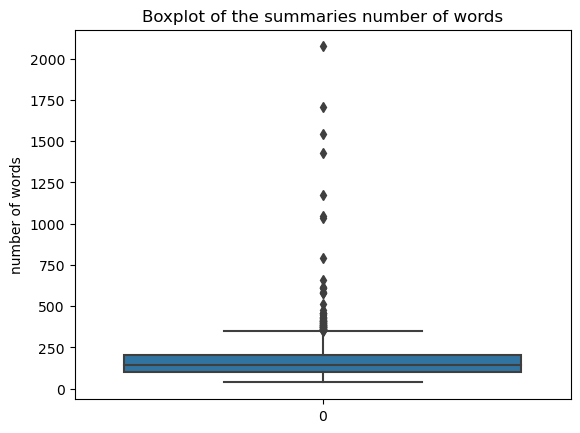

In [14]:
sns.boxplot(df["num_words_summary"])
plt.ylabel("number of words")
plt.title("Boxplot of the summaries number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,summary_lower_whisker,summary_upper_whisker, Q2 = all_lines

print("Upper whisker:", summary_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", summary_lower_whisker)

In [15]:
# removing the samples of very long sequences

new_df = df[(df['num_words_summary'] <= summary_upper_whisker) & (df['num_words_article'] <= article_upper_whisker)]
new_df

,path,article,summary,num_words_article,num_words_summary
0,politics/361.txt,Budget to set scene for election..Gordon Brown...,- Increase in the stamp duty threshold from £6...,532,192
1,politics/245.txt,Army chiefs in regiments decision..Military ch...,"""They are very much not for the good and will ...",496,266
2,politics/141.txt,Howard denies split over ID cards..Michael How...,Michael Howard has denied his shadow cabinet w...,533,225
3,politics/372.txt,Observers to monitor UK election..Ministers wi...,The report said individual registration should...,490,223
4,politics/333.txt,Kilroy names election seat target..Ex-chat sho...,"UKIP's leader, Roger Knapman, has said he is g...",435,185
...,...,...,...,...,...
2219,business/380.txt,India opens skies to competition..India will a...,India will allow domestic commercial airlines ...,222,90
2220,business/192.txt,Yukos bankruptcy 'not US matter'..Russian auth...,Yukos says a US court was entitled to declare ...,394,180
2221,business/248.txt,Survey confirms property slowdown..Government ...,House prices were 11.8% higher on the year in ...,318,120
2222,business/004.txt,High fuel prices hit BA's profits..British Air...,"Rod Eddington, BA's chief executive, said the ...",401,197


# Preparing the data

**we will train on 0.03% if the dataset**

In [16]:
# deleting some columns and shuffling the rows

new_df.drop(columns=["num_words_article","num_words_summary","path"])
new_df = new_df.sample(frac = 0.03)
new_df.reset_index(drop=True, inplace=False)

,path,article,summary,num_words_article,num_words_summary
0,sport/221.txt,Lennon brands Rangers favourites..Celtic's Nei...,"""Without playing at the top of our game, we ha...",212,74
1,tech/019.txt,Intel unveils laser breakthrough..Intel has un...,While work has been done to make some of the c...,474,219
2,politics/222.txt,Voters 'reject EU by two to one'..British vote...,British voters would reject the European const...,314,120
3,sport/309.txt,Murphy: That was a bruising battle..That's wha...,It was not like the days gone by when you coul...,434,183
4,sport/053.txt,Gebrselassie in London triple bid..Double Olym...,"Double Olympic 10,000m champion Haile Gebrsela...",157,78
...,...,...,...,...,...
59,politics/261.txt,Labour's election love-in..Peace and love have...,The event may have been designed to highlight ...,553,239
60,politics/245.txt,Army chiefs in regiments decision..Military ch...,"""They are very much not for the good and will ...",496,266
61,politics/026.txt,Blair sets date for Africa report..The Commiss...,The Commission for Africa's report will be rel...,257,108
62,business/415.txt,UK house prices dip in November..UK house pric...,All areas saw a rise in annual house price inf...,395,168


In [17]:
# splitting the data into train and test 

ratio = 0.8
split = int(len(new_df)*ratio)

train_df = new_df.iloc[:split]
test_df = new_df.iloc[split:]

In [18]:
# convert the DataFrame into DatasetDict

train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'article', 'summary', 'num_words_article', 'num_words_summary'],
        num_rows: 51
    })
    test: Dataset({
        features: ['path', 'article', 'summary', 'num_words_article', 'num_words_summary'],
        num_rows: 13
    })
})

In [19]:
max_input_length = int(article_upper_whisker)
max_target_length = int(summary_upper_whisker)

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [20]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# ROUGE

<div style="background-color:#cdd3dd; color:##cdd3dd; font-size:18px; font-family:cursive; padding:10px; border: 5px solid #19180F;">ROUGE, or Recall-Oriented Understudy for Gisting Evaluation, is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation.

Note that ROUGE is case insensitive, meaning that upper case letters are treated the same way as lower case letters.  </div>

# ROUGE

<div style="background-color:#cdd3dd; color:##cdd3dd; font-size:18px; font-family:cursive; padding:10px; border: 5px solid #19180F;"> Inputs
    
* predictions (list): list of predictions to score. Each prediction should be a string with tokens separated by spaces.
    
* references (list or list[list]): list of reference for each prediction or a list of several references per prediction. Each reference should be a string with tokens separated by spaces.
    
* rouge_types (list): A list of rouge types to calculate. Defaults to ['rouge1', 'rouge2', 'rougeL', 'rougeLsum'].

    Valid rouge types:
    

    "rouge1": unigram (1-gram) based scoring

    "rouge2": bigram (2-gram) based scoring

    "rougeL": Longest common subsequence based scoring.

    "rougeLSum": splits text using "\n"
    

   </div>

<div style="background-color:#cdd3dd; color:##cdd3dd; font-size:18px; font-family:cursive; padding:10px; border: 5px solid #19180F;">
Output Values
    
The output is a dictionary with one entry for each rouge type in the input list rouge_types.

In [21]:
import evaluate

rouge_score = evaluate.load("rouge")

In [22]:
# example on using rouge

generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"
scores = rouge_score.compute(predictions=[generated_summary], references=[reference_summary])
scores

{'rouge1': 0.923076923076923,
 'rouge2': 0.7272727272727272,
 'rougeL': 0.923076923076923,
 'rougeLsum': 0.923076923076923}

In [23]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    
    # Compute ROUGE scores
    result = rouge_score.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    return {k: round(v, 4) for k, v in result.items()}

# Generating Summaries using Pipline 

In [24]:
summarizer = pipeline("summarization", model=model_ckpt)

In [25]:
def print_summary(idx):
    article = dataset["test"][idx]["article"]
    summary = dataset["test"][idx]["summary"]
    g_summary = summarizer(dataset["test"][idx]["article"])[0]["summary_text"]
    score = rouge_score.compute(predictions=[g_summary], references=[summary])
    scores = {k: round(v, 4) for k, v in score.items()}
    print(f"'>>> Article: {article}'")
    print(f"\n'>>> Summary: {summary}'")
    print(f"\n'>>> Generated Summary: {g_summary}'")
    print(f"\n'>>> ROUGE Score: {scores}'")

In [26]:
print_summary(5)

'>>> Article: Slim PlayStation triples sales..Sony PlayStation 2's slimmer shape has proved popular with UK gamers, with 50,000 sold in its first week on sale...Sales have tripled since launch, outstripping Microsoft's Xbox, said market analysts Chart-Track. The numbers were also boosted by the release of the PS2-only game Grand Theft Auto: San Andreas. The title broke the UK sales record for video games in its first weekend of release. Latest figures suggest it has sold more than 677,000 copies..."It is obviously very, very encouraging for Sony because Microsoft briefly outsold them last week," John Houlihan, editor of Computerandvideogames.com told BBC News. "And with Halo 2 [for Xbox] out next week, it really is a head-to-head contest between them and Xbox."..Although Xbox sales over the last week also climbed, PS2 sales were more than double that. The figures mean Sony is reaching the seven million barrier for UK sales of the console. Edinburgh-based developer, Rockstar, which is b

# Fine-tuning BART with BBC News dataset

In [27]:
# creating data_collator 
# A data_collator is a function that takes a batch of data and collates it into a format suitable for model training

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [28]:
# removing the columns with strings because the collator won’t know how to pad these elements

tokenized_datasets = tokenized_datasets.remove_columns(dataset["train"].column_names)

In [29]:
batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_ckpt

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-BBC",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,)

In [30]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,)

Cloning https://huggingface.co/MohamedMagdi191/bart-base-finetuned-BBC into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.40k/532M [00:00<?, ?B/s]

Download file runs/Aug21_11-51-02_570b94baf832/events.out.tfevents.1692618667.570b94baf832.23.0: 100%|########…

Download file training_args.bin: 100%|##########| 4.06k/4.06k [00:00<?, ?B/s]

Clean file runs/Aug21_11-51-02_570b94baf832/events.out.tfevents.1692618667.570b94baf832.23.0:  14%|#3        |…

Clean file training_args.bin:  25%|##4       | 1.00k/4.06k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/532M [00:00<?, ?B/s]

In [31]:
trainer.train()

wandb: Currently logged in as: mmagdy191 (mohamed-magdy). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.8
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230821_134120-qpp81h6j
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run expert-morning-12
wandb: ⭐️ View project at https://wandb.ai/mohamed-magdy/huggingface
wandb: 🚀 View run at https://wandb.ai/mohamed-magdy/huggingface/runs/qpp81h6j
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,0.428186,0.133300,0.092600,0.120100,0.123400
2,1.113100,0.356987,0.135400,0.093200,0.120700,0.122800
3,0.461300,0.274491,0.149300,0.120000,0.140600,0.140800
4,0.461300,0.249667,0.145000,0.117000,0.137400,0.137600
5,0.322100,0.245435,0.152300,0.128500,0.148100,0.148600
6,0.312300,0.245299,0.156700,0.129600,0.151400,0.151900
7,0.312300,0.246349,0.156700,0.129600,0.151400,0.151900
8,0.244400,0.245208,0.156700,0.129600,0.151400,0.151900


TrainOutput(global_step=32, training_loss=0.47384075075387955, metrics={'train_runtime': 91.8772, 'train_samples_per_second': 4.441, 'train_steps_per_second': 0.348, 'total_flos': 176446060277760.0, 'train_loss': 0.47384075075387955, 'epoch': 8.0})

# Inference 

In [32]:
hub_model_id = "MohamedMagdi191/bart-base-finetuned-BBC"
summarizer = pipeline("summarization", model=hub_model_id)

In [33]:
"""
def test(dataset):
    summary = dataset["test"]["summary"]
    g_summary = [summarizer(dataset["test"][idx]["article"])[0]["summary_text"] for idx in range(len(dataset["test"]))]
    score = rouge_score.compute(predictions=g_summary, references=summary)
    scores = {k: round(v, 4) for k, v in score.items()}
    print(f"\n'>>> ROUGE Score: {scores}'")
"""

'\ndef test(dataset):\n    summary = dataset["test"]["summary"]\n    g_summary = [summarizer(dataset["test"][idx]["article"])[0]["summary_text"] for idx in range(len(dataset["test"]))]\n    score = rouge_score.compute(predictions=g_summary, references=summary)\n    scores = {k: round(v, 4) for k, v in score.items()}\n    print(f"\n\'>>> ROUGE Score: {scores}\'")\n'

In [34]:
# commenting this line because it takes too much time 
# test(dataset)

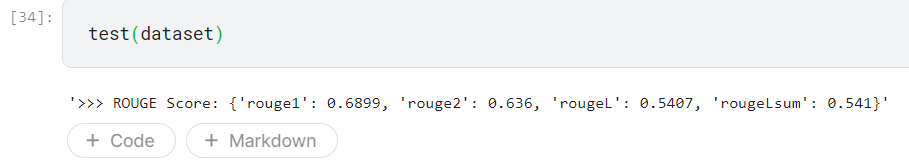

# References

* Large Language Model's Architectural Diagrams: https://www.kaggle.com/datasets/suraj520/notebook-images
* HuggingFace NLP course: https://huggingface.co/learn/nlp-course/chapter7/5?fw=pt#metrics-for-text-summarization
* Rouge metric: https://huggingface.co/spaces/evaluate-metric/rouge